# Individual Project
### Using the python program FloPy to run the USGS MODFLOW-2005 ground-water model.

### Learning Goals
> Download FloPy and Get it Working

> Use the Unsaturated Zone Flow package to create a one-layer model of the unsaturated zone with varying parameters.

> Run MODFLOW-2005 with the UZF package using FloPy 

> Analyze changes in water content at a cell over time

### Unsaturated-Zone Flow Package
> Designed to simulate infiltration through an unsaturated zone between land surface and the water table. The package can account for land surface runoff to streams and lakes.  

### Model Specifications
* Grid dimensions: 1 Layer, 15 Rows, 10 Columns  
* Stress periods: 12  
* Units are in seconds and days
* Flow package: Layer-Property Flow (LPF)  
* Stress packages: Sream-Flow Routing (SFR), General Head Boundary (GHB), Unsaturated Zone Flow (UZF) 
* Solver: Strongly Implicit Procedure (SIP)  

## How to View this Notebook:
> A) Setup to run FloPy

> B) Pre-processing

> C) Post-processing

> D) Analysis

# A) Setup to run FloPy

In [260]:
import os
import sys
import glob
import platform
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('pandas version: {}'.format(pd.__version__))

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

print('flopy version: {}'.format(flopy.__version__))

3.7.9 (default, Sep  1 2020, 07:16:07) [MSC v.1916 32 bit (Intel)]
numpy version: 1.19.2
matplotlib version: 3.3.1
pandas version: 1.1.3
flopy version: 3.3.3


### Making sure FloPy points to the correct executable. 
This will change depending on which type of MODFLOW you are using, -2005, -6, -7, -NWT, etc.

In [261]:
exe_name = 'C:\\Users\\ccoro\\GIT\\flo\\flopy\\MF2005.1_12\\bin\\mf2005' #Set name of MODFLOW exe, executable should be in users path statement
if platform.system() == 'Windows':
    exe_name += '.exe'
    
path = 'temp' #C:\Users\ccoro\GIT\flo\examples\Notebooks\temp
if not os.path.isdir(path):
    os.mkdir(path)
gpth = os.path.join('..', 'data', 'mf2005', 'project.*') #C:\Users\ccoro\GIT\flo\examples\data\mf2005
for f in glob.glob(gpth):
    shutil.copy(f, path)

#### Clean out any previous UZF external file references 
(This is so they don't conflict with the ones made by flopy)

In [262]:
m = flopy.modflow.Modflow.load('project.nam', version='mf2005', exe_name=exe_name, 
                               model_ws=path, load_only=['ghb', 'dis', 'bas6', 'oc', 'sip', 'lpf', 'sfr'])
print("All set!")

All set!


In [263]:
m.external_fnames

['temp\\project.uzfot',
 'temp\\project.uzf1',
 'temp\\project.uzf2',
 'temp\\project.uzf3',
 'temp\\project.uzf4',
 'temp\\project.sg1',
 'temp\\project.sg2',
 'temp\\project.sg3',
 'temp\\project.sg4',
 'temp\\project.sg5',
 'temp\\project.sg6',
 'temp\\project.sg7',
 'temp\\project.sg8',
 'temp\\projectdv.sg9']

In [265]:
rm = [True if '.uz' in f else False for f in m.external_fnames]
m.external_fnames = [f for i, f in enumerate(m.external_fnames) if not rm[i]]
m.external_fnames
m.external_binflag = [f for i, f in enumerate(m.external_binflag) if not rm[i]]
m.external_output = [f for i, f in enumerate(m.external_output) if not rm[i]]
m.external_units = [f for i, f in enumerate(m.external_output) if not rm[i]]

# B) Pre-processing
For my project, I decided to create a meandering river in a matrix of 15 rows and 10 columns. 
- The model grid is divided uniformly into cells with a length of 5,000 ft on each side.
- There are five important ".dat" files that the user must change based on their research questions. 
- These `.dat` files may be found at `../flo/examples/data/project/`

1) __bnd.dat:__ An array of integer values used to define the active cells.

2) __irunbnd.dat__: An array of integer values used to define the stream segments in the Streamflow-Routing (SFR2) Package.

3) __vks.dat__:	Vertical hydraulic conductivity of the unsaturated zone

4) __finf.dat__: An array of integer values used to define the infiltration rates per cell per period.

5) __extwc.dat__: An array of integer values used to define the evapotranspiration extinction depth. ET can only be removed at a depth shallower than the extinction depth.

### First we set up the active cells with (1) `bnd.dat`

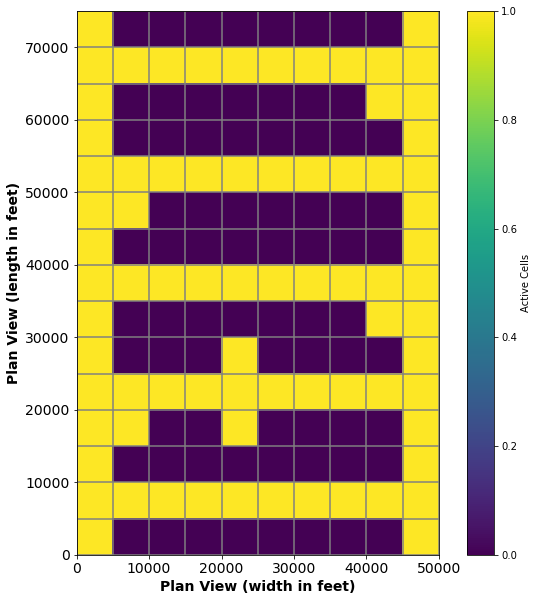

In [319]:
bndpth = os.path.join('..', 'data', 'project', 'bnd.dat') 
bnd = np.loadtxt(bndpth)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=m)
irunbndplt = mapview.plot_array(bnd)
plt.colorbar(irunbndplt, ax=ax, label='Active Cells')
plt.xlabel('Plan View (width in feet)', fontsize = 14, fontweight ='bold')
plt.ylabel('Plan View (length in feet)', fontsize = 14, fontweight ='bold')
linecollection = mapview.plot_grid()
ax.tick_params(labelsize=14)

### (2) Set up the ```irunbnd``` array  

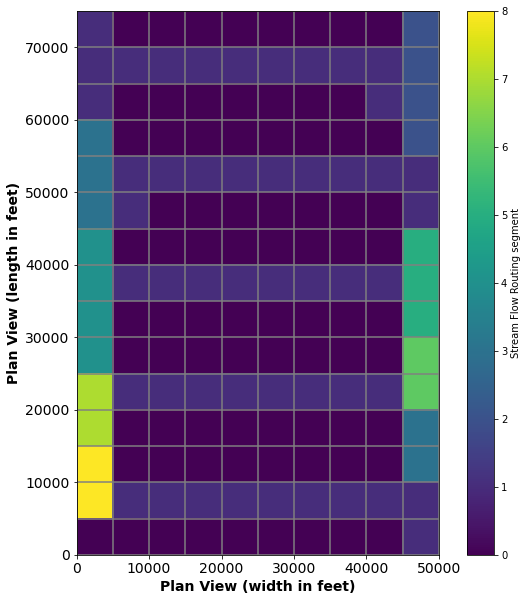

In [320]:
irnbndpth = os.path.join('..', 'data', 'project', 'irunbnd.dat') 
irunbnd = np.loadtxt(irnbndpth)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=m)
irunbndplt = mapview.plot_array(irunbnd)
plt.colorbar(irunbndplt, ax=ax, label='Stream Flow Routing segment')
plt.xlabel('Plan View (width in feet)', fontsize = 14, fontweight ='bold')
plt.ylabel('Plan View (length in feet)', fontsize = 14, fontweight ='bold')
linecollection = mapview.plot_grid()
ax.tick_params(labelsize=14)

### (3) Set up the ``vks`` (unsaturated zone vertical hydraulic conductivity) array
Note: Layer 1 is the only layer.

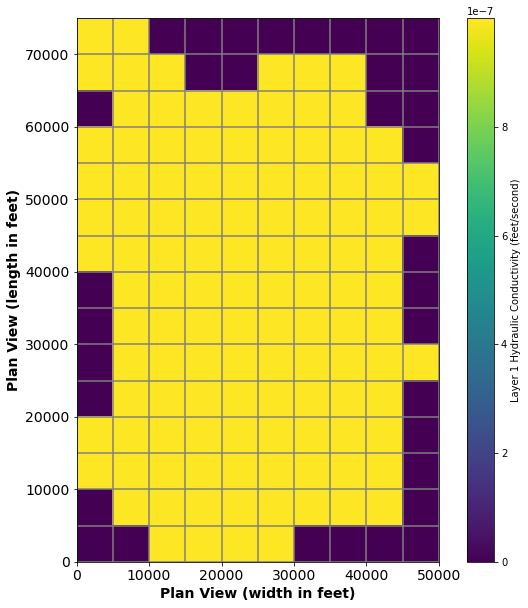

In [322]:
vksbndpth = os.path.join('..', 'data', 'project', 'vks.dat')
vks = np.loadtxt(vksbndpth)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=m)
vksplt = mapview.plot_array(vks)
plt.colorbar(vksplt, ax=ax, label='Layer 1 Hydraulic Conductivity (feet/second)')
plt.xlabel('Plan View (width in feet)', fontsize = 14, fontweight ='bold')
plt.ylabel('Plan View (length in feet)', fontsize = 14, fontweight ='bold')
linecollection = mapview.plot_grid()
ax.tick_params(labelsize=14)

### (4) Set up the `finf` array  
* `finf` can be submitted to FloPy as a 3D array, list of 2D arrays, list of numeric values, or single numeric value.

In [276]:
m.nrow_ncol_nlay_nper

(15, 10, 1, 12)

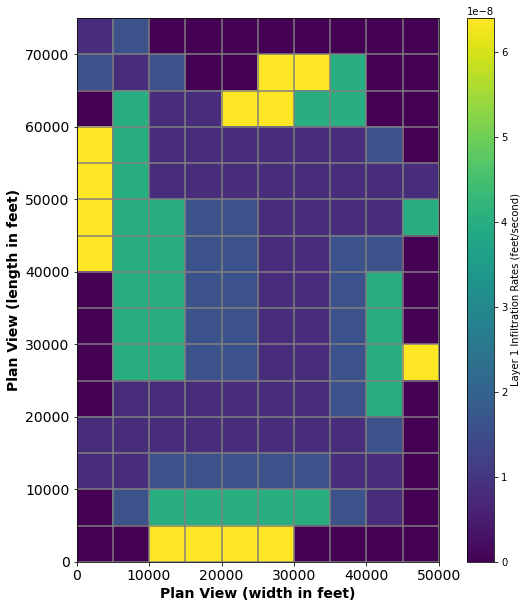

In [323]:
finf = np.loadtxt(os.path.join('..', 'data', 'project', 'finf.dat'))
finf = np.reshape(finf, (m.nper, m.nrow, m.ncol))
finf = {i: finf[i] for i in range(finf.shape[0])}

# plot using PlotMapView
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=m)
quadmesh = mapview.plot_array(finf[1])
plt.colorbar(quadmesh, label='Layer 1 Infiltration Rates (feet/second)')
plt.xlabel('Plan View (width in feet)', fontsize = 14, fontweight ='bold')
plt.ylabel('Plan View (length in feet)', fontsize = 14, fontweight ='bold')
linecollection = mapview.plot_grid()
ax.tick_params(labelsize=14)

### (5) Setup the `extwc` (extinction water content) array

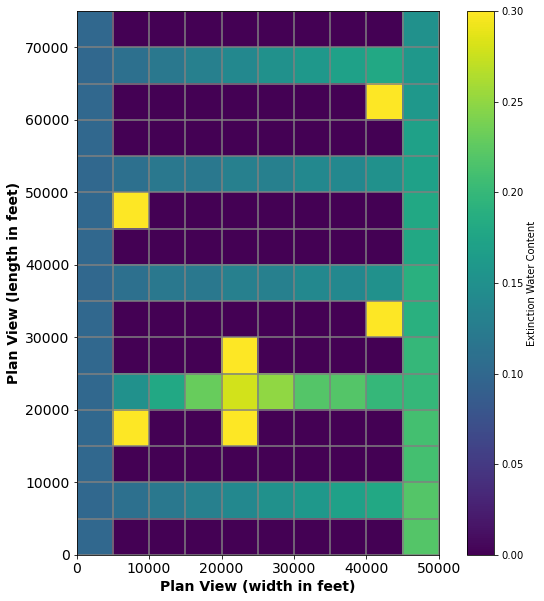

In [329]:
extwc = np.loadtxt(os.path.join('..', 'data', 'project', 'extwc.dat'))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

mapview = flopy.plot.PlotMapView(model=m)
quadmesh = mapview.plot_array(extwc)
plt.colorbar(quadmesh, label='Extinction Water Content')
plt.xlabel('Plan View (width in feet)', fontsize = 14, fontweight ='bold')
plt.ylabel('Plan View (length in feet)', fontsize = 14, fontweight ='bold')
linecollection = mapview.plot_grid()
ax.tick_params(labelsize=14)

### Set Up the Observation Points:
* supplied as a dictionary keyed by `IFTUNIT`
* A positive value [of `IFTUNIT`] is for output of individual cells whereas a negative value is for output that is summed over all model cells. 
* values are a list of `[IUZROW, IUZCOL, IFTUNIT, IUZOPT]`
* `IUZROW` and `IUZCOL` are zero based

In [327]:
uzgag = {-68: [-68],
         65: [2, 5, 65, 1], #Print time, head, uz thickness and cum. vols of infiltration, recharge, storage, change in storage and ground-water discharge to land surface.
         66: [5, 2, 66, 2], #Same as option 1 except rates of infiltration, recharge, change in storage, and ground-water discharge also are printed.
         67: [9, 4, 67, 3]} #Prints time, ground-water head, thickness of unsaturated zone, followed by a series of depths and water contents in the unsaturated zone. 

### Make the UZF package

In [230]:
uzf = flopy.modflow.ModflowUzf1(m,
                                nuztop=1, iuzfopt=1, irunflg=1, ietflg=1,
                                ipakcb=0, 
                                iuzfcb2=61,# binary output of recharge and groundwater discharge
                                ntrail2=25, nsets=20,
                                surfdep=1.0, uzgag=uzgag,
                                iuzfbnd=m.bas6.ibound.array, 
                                irunbnd=irunbnd, 
                                vks=vks, # saturated vertical hydraulic conductivity of the uz
                                finf=finf, #infiltration rates
                                eps=3.3, # Brooks-Corey relation of water content to hydraulic conductivity (epsilon)
                                thts = 0.2, # saturated water content of the uz in units of volume of water to total volume
                                pet=2.000000E-08, # potential ET
                                extdp=20., # ET extinction depth(s)
                                extwc=extwc, #extinction water content below which ET cannot be removed from the unsaturated zone
                                unitnumber=19)

In [231]:
m.write_input()

### RUN THE MODEL

In [328]:
success, buff = m.run_model()
if not success:
    print('"{}...did not run"'.format(m.name))

FloPy is using the following  executable to run the model: C:\Users\ccoro\GIT\flo\flopy\MF2005.1_12\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: project.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/12/10 19:09:53

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     

# C) Post-processing

## Results

### This is the water budget output

In [233]:
fpth = os.path.join(path,'project.uzfcb2.bin')
avail = os.path.isfile(fpth)
if avail:
    uzfbdobjct = flopy.utils.CellBudgetFile(fpth)
    uzfbdobjct.list_records()
else:
    print('"{}" is not available'.format(fpth))

(1, 1, b'           GW ET', 10, 15, -1, 4, 2628000., 2628000., 2628000., b'', b'', b'', b'')
(1, 1, b'    UZF RECHARGE', 10, 15, -1, 4, 2628000., 2628000., 2628000., b'', b'', b'', b'')
(1, 1, b' SURFACE LEAKAGE', 10, 15, -1, 4, 2628000., 2628000., 2628000., b'', b'', b'', b'')
(1, 1, b'       HORT+DUNN', 10, 15, -1, 4, 2628000., 2628000., 2628000., b'', b'', b'', b'')
(1, 1, b'  STORAGE CHANGE', 10, 15, -1, 4, 2628000., 2628000., 2628000., b'', b'', b'', b'')
(1, 2, b'           GW ET', 10, 15, -1, 4, 82713.07, 82713.07, 2710713., b'', b'', b'', b'')
(1, 2, b'    UZF RECHARGE', 10, 15, -1, 4, 82713.07, 82713.07, 2710713., b'', b'', b'', b'')
(1, 2, b' SURFACE LEAKAGE', 10, 15, -1, 4, 82713.07, 82713.07, 2710713., b'', b'', b'', b'')
(1, 2, b'       HORT+DUNN', 10, 15, -1, 4, 82713.07, 82713.07, 2710713., b'', b'', b'', b'')
(1, 2, b'  STORAGE CHANGE', 10, 15, -1, 4, 82713.07, 82713.07, 2710713., b'', b'', b'', b'')
(5, 2, b'           GW ET', 10, 15, -1, 4, 121100.21, 504971.6, 313297

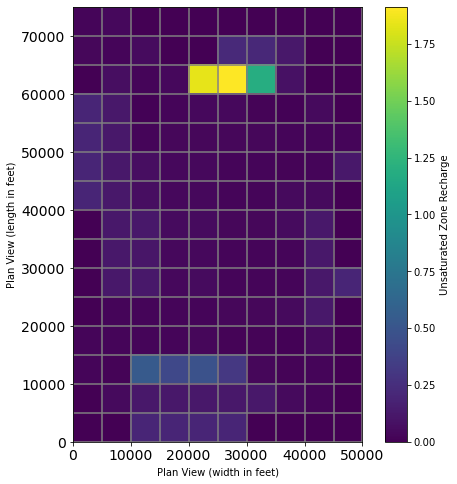

In [331]:
if success and avail:
    r = uzfbdobjct.get_data(text='UZF RECHARGE')
    et = uzfbdobjct.get_data(text='GW ET')
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
    mapview = flopy.plot.PlotMapView(model=m)
    quadmesh = mapview.plot_array(r[6])
    plt.colorbar(quadmesh, label='Unsaturated Zone Recharge')
    plt.xlabel('Plan View (width in feet)')
    plt.ylabel('Plan View (length in feet)')
    linecollection = mapview.plot_grid()
    ax.tick_params(labelsize=14)

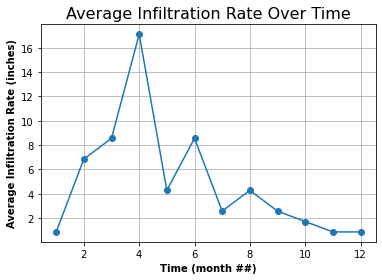

In [352]:
plt.plot(m.dis.perlen.array.cumsum()/2628288, 
         [a.mean() * 86400 * 365 * 12 for a in finf.values()], marker='o')
plt.xlabel('Time (month ##)', fontsize = 10, fontweight ='bold')
plt.ylabel('Average Infiltration Rate (inches)', fontsize = 10, fontweight ='bold');
ax.tick_params(labelsize=14)
plt.title("Average Infiltration Rate Over Time", fontsize=16)
plt.grid()

## Average infiltration was highest in the early Spring (where 04 = April). 
Infiltration was lowest in the fall and winter months (September - February)

### Look at the Observation Points

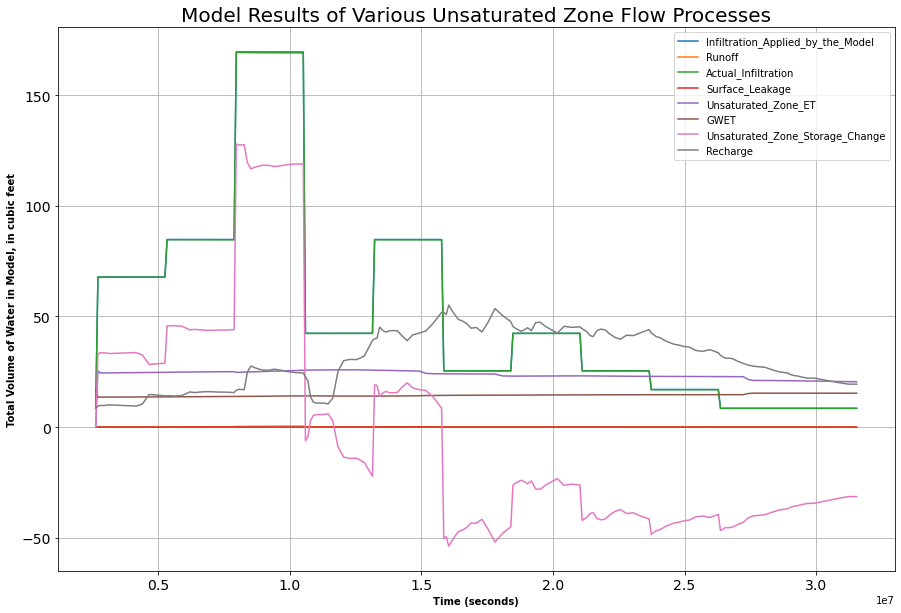

In [383]:
fpth = os.path.join(path, 'project.uzf68.out')
avail = os.path.isfile(fpth)
#avail = round(avail, 3)
if avail:
    dtype = [('Time', np.float), 
             ("Infiltration Applied by the Model", np.float), 
             ('Runoff', np.float), 
             ('Actual Infiltration', np.float), 
             ('Surface Leakage', np.float), 
             ('Unsaturated Zone ET', np.float), 
             ('GW-ET', np.float), 
             ('Unsaturated Zone Storage Change', np.float), 
             ('Recharge', np.float)]
    # read data from file
    df = np.genfromtxt(fpth, skip_header=3, dtype=dtype)
    # convert numpy recarray to pandas dataframe
    df = pd.DataFrame(data=df)
    # set index to the time column
    df.set_index(['Time'], inplace=True)
    # plot the data
    ax = df.plot(legend=False, figsize=(15, 10))
    patches, labels = ax.get_legend_handles_labels()
    plt.title("Model Results of Various Unsaturated Zone Flow Processes", fontsize=20)
    plt.grid()
    ax.legend(patches, labels, loc=1)
    ax.tick_params(labelsize=14)
    ax.set_ylabel('Total Volume of Water in Model, in cubic feet', fontsize = 10, fontweight ='bold')
    ax.set_xlabel('Time (seconds)', fontsize = 10, fontweight ='bold')

### Water Content Profile At Row 14, Column 9, Over Time

In [384]:
fpth = os.path.join(path, 'project.uzf67.out')
avail = os.path.isfile(fpth)
if avail:
    data = []
    with open(fpth) as input:
        for i in range(3):
            next(input)
        for line in input:
            line = line.strip().split()
            if len(line) == 6:
                layer = int(line.pop(0))
                time = float(line.pop(0)) / 86400
                time = round(time, 1)
                head = float(line.pop(0))
                uzthick = float(line.pop(0))
            depth = float(line.pop(0))
            depth = round(depth, 1)
            watercontent = float(line.pop(0))
            data.append([layer, time, head, uzthick, depth, watercontent])

In [385]:
if avail:
    df3 = pd.DataFrame(data, columns=['layer', 'time', 'head', 'uzthick', 'depth', 'watercontent'])
    df3.head(41)

In [386]:
if avail:
    wc = df3.watercontent.values.reshape(len(df3.time.unique()), 40).T
    wc = pd.DataFrame(wc, columns=df3.time.unique(), index=df3.depth[0:40])
    wc.head()

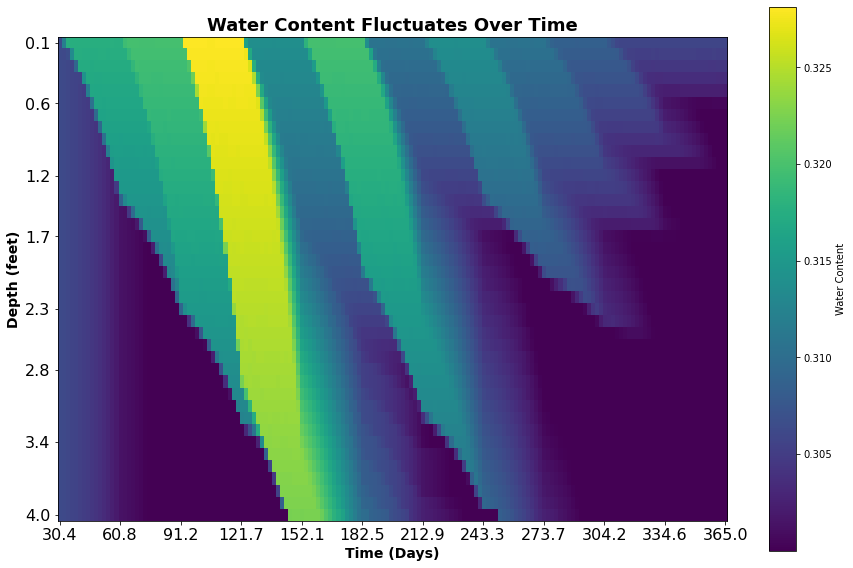

In [387]:
if avail:
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.imshow(wc, interpolation='None')
    ax.set_aspect(3)
    r, c = wc.shape
    xcol_locs = np.linspace(0, c-1, 12, dtype=int)
    ycol_locs = np.linspace(0, r-1, 8, dtype=int)
    ax.set_xticks(xcol_locs)

    xlabels = wc.columns
    ax.set_xticklabels(xlabels[xcol_locs])
    ax.set_ylabel('Depth (feet)', fontsize = 14, fontweight ='bold')
    ax.set_yticks(ycol_locs)
    ax.set_yticklabels(wc.index[ycol_locs])
    ax.set_xlabel('Time (Days)', fontsize = 14, fontweight ='bold')
    ax.tick_params(labelsize=16)
    plt.colorbar(label='Water Content')
    ax.set_title('Water Content Fluctuates Over Time', fontsize = 18, fontweight ='bold')

### The 2D graph shows a time serioes of the changing wetting fronts at one subsurface cell.
That cell is located on Row 14, Column 9 (see above).

There are 12 periods, each of which is represented by ~30 days. Every period has 15 time steps, so each time step is about 2 days. The first time period is not shown (0 - 30.4 days) because no changes occur, the graph would just show the steady state water content of ~0.31 (purple). You can see the other 11 periods in the form of these wetting fronts. The 5th wetting front occurs between days ~121 to 152, which signifies the end of April through May. This coincides with the earlier graph (average infiltration) which also shows that average infiltration increased during the April/May months before decreasing.

The fact that this 2D plot matches the 1D simple average infiltration plot is a good indication that the model successfully ran and created reasonable output. That concludes my individual group project, where my goal was to get FloPy working on my machine, make a model, and analyze it for accuracy. 

Thanks!
